In [1]:
#!conda install -c conda-forge metpy -y

In [2]:
# !pip install metpy

In [3]:
# !pip uninstall scipy

In [7]:
import xarray as xr
import numpy as np
import xarray as xr
# from metpy.calc import potential_temperature, absolute_vorticity
# from metpy.constants import Rd, Cp
# from metpy.units import units
import scipy.ndimage #import gaussian_filter

In [8]:
import metpy.calc as mpcalc
from metpy.units import units

In [19]:
!ls /media/ms86336/SSD\ 2/backup_ssd2/shweta/ua_day/ua_day_EC-Earth3-Veg-LR_ssp585_r1i1p1f1_gr_20500101-20501231.nc

'/media/ms86336/SSD 2/backup_ssd2/shweta/ua_day/ua_day_EC-Earth3-Veg-LR_ssp585_r1i1p1f1_gr_20500101-20501231.nc'


In [28]:
filepath = '/media/ms86336/SSD 2/backup_ssd2/shweta/ua_day/ua_day_EC-Earth3-Veg-LR_ssp585_r1i1p1f1_gr_20500101-20501231.nc'
ds_ua_ssp585 = xr.open_mfdataset(filepath)
filepath = '/media/ms86336/SSD 2/backup_ssd2/shweta/va_day/va_day_EC-Earth3-Veg-LR_ssp585_r1i1p1f1_gr_20500101-20501231.nc'
ds_va_ssp585 = xr.open_mfdataset(filepath)
filepath = '/media/ms86336/SSD 2/backup_ssd2/shweta/hus_day/hus_day_EC-Earth3-Veg-LR_ssp585_r1i1p1f1_gr_20500101-20501231.nc'
ds_hus_ssp585 = xr.open_mfdataset(filepath)
ds_tas_ssp585 = xr.open_mfdataset('/media/ms86336/SSD 2/backup_ssd2/shweta/tas_day/tas_day_EC-Earth3-Veg-LR_ssp585_r1i1p1f1_gr_20500101-20501231.nc')

In [29]:
import metpy.calc as mpcalc

In [30]:
# Calculate the vertical vorticity of the flow
# 🔹 Extract Relevant Variables
ua_850 = ds_ua_ssp585['ua'].sel(plev=85000)  # 850 hPa zonal wind (m/s)
va_850 = ds_va_ssp585['va'].sel(plev=85000)  # 850 hPa meridional wind (m/s)
vort = mpcalc.vorticity(ua_850, va_850)

In [31]:
vort

<xarray.DataArray 'sub-2b9f46389704992c9dc7b5053c8919aa' (time: 365, lat: 160,
                                                          lon: 320)> Size: 150MB
<Quantity(dask.array<sub, shape=(365, 160, 320), dtype=float64, chunksize=(1, 160, 320), chunktype=numpy.ndarray>, '1 / second')>
Coordinates:
  * time     (time) datetime64[ns] 3kB 2050-01-01T12:00:00 ... 2050-12-31T12:...
    plev     float64 8B 8.5e+04
  * lat      (lat) float64 1kB -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 3kB 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9

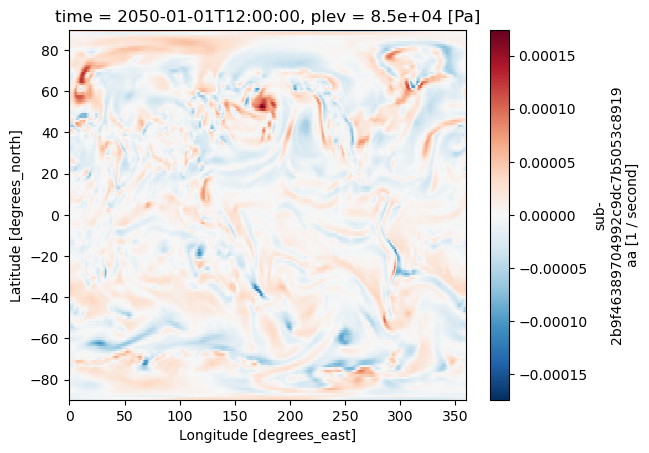

In [32]:
vort.isel(time=0).plot()

In [33]:
# Calculate the stretching deformation of the flow
str_def = mpcalc.stretching_deformation(ua_850, va_850)

In [34]:
# Calculate the shearing deformation of the flow
shr_def = mpcalc.shearing_deformation(ua_850, va_850)

In [35]:
# Compute Okubo-Weiss-Zeta parameter (OWZP)
zeta = vort
stretching = str_def
shearing = shr_def
ow_norm = (zeta**2 - (stretching**2 + shearing**2)) / (zeta**2)
owzp = np.maximum(ow_norm, 0) * zeta

In [36]:
# Apply Gaussian smoothing to filter small-scale noise
owzp = scipy.ndimage.gaussian_filter(owzp, sigma=1.5)

In [37]:
owzp.shape

(365, 160, 320)

In [38]:
vort['owzp'] = (('time', 'lat', 'lon'), owzp)

In [39]:
# Threshold for TC detection (adjust based on model resolution)
TC_THRESHOLD = 1e-5  # Example value, refine as needed
tc_mask = owzp > TC_THRESHOLD

In [40]:
vort['tc_mask'] = (('time', 'lat', 'lon'), tc_mask)

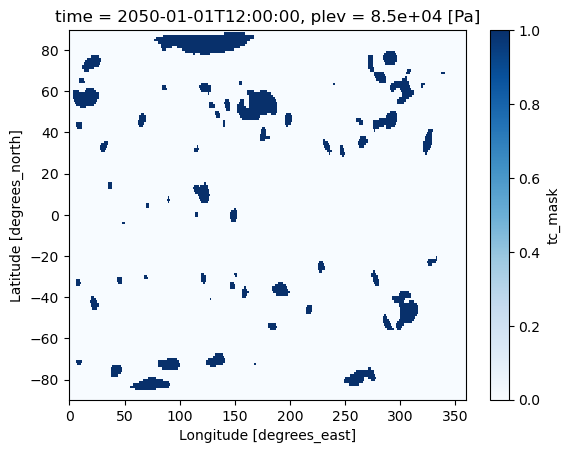

In [41]:
vort.tc_mask.isel(time=0).plot(cmap='Blues')